<a href="https://colab.research.google.com/github/snarvekark/NeuralNetworkClassifier/blob/main/NeuralNetworkClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#FEVER Paper 

##Automated Fact-Checking of Claims in Argumentative Parliamentary Debates

##Link: https://www.aclweb.org/anthology/W18-5509/

#Summary

The paper discusses about detecting fake news during Political debates. They present an automated approach to distinguish true, false, stretch, and dodge statements in questions and answers in the Canadian Parliament. They leverage the truthfulness annotations of a U.S. factchecking corpus by training a neural net model and incorporating the prediction probabilities into our models. Further they find that in concert with other linguistic features, these probabilities can improve the multi-class classification results. They also found that check-worthy actual claims were more likely to contain numeric values and non-factual sentences were less likely to contain numeric values. 

#Dataset Used in FEVER Paper

The dataset used from the Canada Newspaper ‘The Star’. In this research paper the detection is performed using a Neural Network to label the news as true, false, stretch and dodge statement. Further they also leveraged data from Politifact and utilized Gated Recurrent Unit Classifier. 

#FEVER Paper Comparison

In the Alternus Vera project 36 factors were considered and each of these factors were explored and implemented for detecting Fake news. Although this was a broader umbrella set, each of these factors were equally justified by utilizing different NLP feature extraction and distillation methods. This enabled including all possible factors affecting the detection of Fake news.

Whereas in the FEVER paper the focus area was concentrated only on Political arguments in the Parliament. This limited the information in the dataset to discussions and comments made during these arguments and did not include general political news to a larger extent.

Thus, the Alternus Vera project was a broader and detailed Fake news detection project that included information from different base areas including but not limited to only news portal and helped efficient detection of Fake News.    


# Fake News Classification using Neural Network

#Data Narrative

For the FEVER paper the initial dataset used is the Canada Political dataset from the newspaper The Star.
However the further work from the co-authors makes use of the US Politifact Dataset and its six label classification.

Hence for this program we are using the Politifacat dataset with six way classfication.

The methodology impleemented using the Politifact dataset is neural network and other word embedding such as LDA, Glove and Sentiment to name a few.

Hence for this program some of the embedding technique are implemented and a neural network model is used.

#Import Libraries

In [1]:
import pandas as pd
import numpy as np
import csv
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from nltk.stem.porter import PorterStemmer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from string import punctuation
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import re
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
import matplotlib.pyplot as plt
from scipy import sparse

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


#Install Tensorflow

In [2]:
# First we import the required libraries

import tensorflow as tf
import random
import numpy as np
import pandas as pd
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import io

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K 
K.clear_session()

# Check tensorflow version
if float(tf.__version__[0]) < 2.0:
  print('Updating tensorflow')
  !pip install tensorflow==2.0
else:
  print('Correct version of Tensorflow installed.')

Correct version of Tensorflow installed.


#Dataset

Here we are using the Liar Liar dataset to classify the news as Fake or Not using the Neural Network model

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1sFMftHLILNfuS0kpTlsbUzWpSNs3WkeD"})
downloaded.GetContentFile('liar_plus_dataset.zip')

In [4]:
from zipfile import ZipFile

The dataset is divided into three sets, Train, Test and Validation data

In [5]:
with ZipFile('liar_plus_dataset.zip', 'r') as myzip:
    train_data = myzip.open('train2.tsv')
    test_data = myzip.open('test2.tsv')
    valid_data = myzip.open('val2.tsv')

train_news = pd.read_csv(train_data, sep='\t', header=None).drop([0], axis=1).dropna(how='all')
test_news = pd.read_csv(test_data, sep='\t', header=None).drop([0], axis=1).dropna(how='all')
valid_news = pd.read_csv(valid_data, sep='\t', header=None).drop([0], axis=1).dropna(how='all')

In [7]:
# Retrieve the data

train_news.count()

1     10240
2     10240
3     10240
4     10238
5     10238
6      7343
7      8032
8     10238
9     10238
10    10238
11    10238
12    10238
13    10238
14    10138
15    10154
dtype: int64

As ca nbe seen there are Null values in some of the columns

In [8]:
train_news.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."


Since the columns are not labeled we rename them

In [6]:
colnames = ['jsonid', 'label', 'headline_text', 'subject', 'speaker', 'speakerjobtitle', 'stateinfo','partyaffiliation', 'barelytruecounts', 'falsecounts','halftruecounts','mostlytruecounts','pantsonfirecounts','context', 'text']


In [7]:
column_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
#new_names = ['a','b','c','d']
old_names = train_news.columns[column_indices]
train_news.rename(columns=dict(zip(old_names, colnames)), inplace=True)
test_news.rename(columns=dict(zip(old_names, colnames)), inplace=True)
valid_news.rename(columns=dict(zip(old_names, colnames)), inplace=True)

In [ ]:
train_news.head()

,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,context,text
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."


In [ ]:
train_news.dtypes

jsonid                object
label                 object
headline_text         object
subject               object
speaker               object
speakerjobtitle       object
stateinfo             object
partyaffiliation      object
barelytruecounts     float64
falsecounts          float64
halftruecounts       float64
mostlytruecounts     float64
pantsonfirecounts    float64
context               object
text                  object
dtype: object

In [8]:
#Use Scikit learn to convert string value to categorical
#Referrence: https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
train_news['label_cat'] = labelencoder.fit_transform(train_news['label'])
test_news['label_cat'] = labelencoder.fit_transform(test_news['label'])

In [ ]:
train_news.head()

,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,context,text,label_cat
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...,1
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe...",2
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...,3
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...,1
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start...",2


##Data Cleaning and Text Preprocessing#

In [9]:
train_news['text'] = train_news['text'].astype(str)
test_news['text'] = test_news['text'].astype(str)

In [10]:
train_news = train_news.append(test_news, ignore_index=True)

In [ ]:
train_news.head()

,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,context,text,label_cat
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...,1
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe...",2
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...,3
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...,1
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start...",2


In [ ]:
train_news.shape

(11507, 16)

#Sentiment Analysis

In [12]:
import nltk
nltk.download('vader_lexicon')
import warnings
import nltk.sentiment
warnings.filterwarnings('ignore')

senti = nltk.sentiment.vader.SentimentIntensityAnalyzer()

def print_sentiment_scores(sentence):
    snt = senti.polarity_scores(sentence)
    print("{:-<40} \n{}".format(sentence, str(snt)))
    
print_sentiment_scores(train_news['text'][0])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
That's a premise that he fails to back up. Annie's List makes no bones about being comfortable with candidates who oppose further restrictions on late-term abortions. Then again, this year its backing two House candidates who voted for more limits. 
{'neg': 0.113, 'neu': 0.788, 'pos': 0.099, 'compound': -0.1531}


In [13]:
def get_vader_polarity(snt):
    if not snt:
        return None
    elif snt['neg'] > snt['pos'] and snt['neg'] > snt['neu']:
        return -1
    elif snt['pos'] > snt['neg'] and snt['pos'] > snt['neu']:
        return 1
    else:
        return 0

In [14]:
#Function to determine if a text is negative(-1) or postive (1) or neutral (0)
def get_polarity_type(sentence):
    sentimentVector = []
    snt = senti.polarity_scores(sentence)
    sentimentVector.append(get_vader_polarity(snt))
    sentimentVector.append(snt['neg'])
    sentimentVector.append(snt['neu'])
    sentimentVector.append(snt['pos'])
    sentimentVector.append(snt['compound'])
    
    print(sentimentVector)
    return sentimentVector

In [16]:
sentiment = []
vader_pol = []
cmp_score = []
for row in train_news['text']:
    get_pols = get_polarity_type(row)
    sentiment.append(get_pols[1:])
    vader_pol.append(get_pols[0])
    cmp_score.append(get_pols[1:][-1]) #last element 
    
train_news['sentiment_vector'] = sentiment
train_news['vader_polarity'] = vader_pol
train_news['sentiment_score'] = cmp_score

Streaming output truncated to the last 5000 lines.
[0, 0.023, 0.891, 0.086, 0.7346]
[0, 0.0, 0.854, 0.146, 0.6486]
[0, 0.092, 0.841, 0.067, -0.3664]
[0, 0.031, 0.809, 0.16, 0.8658]
[0, 0.017, 0.97, 0.013, -0.0772]
[0, 0.072, 0.79, 0.138, 0.2718]
[0, 0.076, 0.899, 0.025, -0.6369]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.154, 0.801, 0.045, -0.7152]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.052, 0.871, 0.077, 0.5256]
[0, 0.248, 0.665, 0.088, -0.6486]
[0, 0.059, 0.941, 0.0, -0.5574]
[0, 0.189, 0.71, 0.101, -0.6486]
[0, 0.0, 0.976, 0.024, 0.25]
[0, 0.0, 0.769, 0.231, 0.7184]
[0, 0.148, 0.812, 0.04, -0.8102]
[0, 0.0, 0.946, 0.054, 0.6486]
[0, 0.065, 0.897, 0.038, -0.5463]
[0, 0.033, 0.885, 0.082, 0.6092]
[0, 0.119, 0.747, 0.134, 0.0335]
[0, 0.083, 0.882, 0.035, -0.4215]
[0, 0.066, 0.825, 0.109, 0.2047]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.027, 0.684, 0.289, 0.9545]
[0, 0.025, 0.875, 0.1, 0.6808]
[0, 0.0, 0.943, 0.057, 0.5106]
[0, 0.0, 0.96, 0.04, 0.6124]
[0, 0.094, 0.832, 0.074, -0.3182]
[0, 0.139, 0.821, 0.04, -0.9898]


In [17]:
train_news.head()

,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,context,text,label_cat,sentiment_vector,vader_polarity,sentiment_score
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...,1,"[0.113, 0.788, 0.099, -0.1531]",0,-0.1531
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe...",2,"[0.05, 0.742, 0.208, 0.9593]",0,0.9593
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...,3,"[0.059, 0.872, 0.068, 0.1779]",0,0.1779
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...,1,"[0.114, 0.804, 0.082, -0.3058]",0,-0.3058
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start...",2,"[0.022, 0.901, 0.077, 0.4384]",0,0.4384


##Glove Word Embedding

In [18]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
train_news['length'] = train_news['headline_text'].apply(lambda x: len(x.split(' ')))

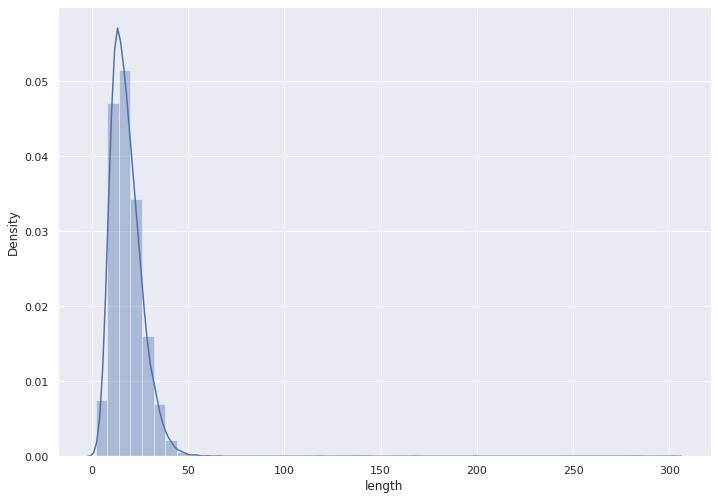

In [19]:
sns.distplot(train_news['length'])

In [ ]:
train_news['length'].describe

<bound method NDFrame.describe of 0        11
1        24
2        19
3        12
4        10
         ..
10237    17
10238    14
10239    28
10240    11
10241    30
Name: length, Length: 10240, dtype: int64>

In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

## Adding in some more useful packages here
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')

from wordcloud import WordCloud
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [22]:
embeddings_index = {}
f = open('/content/drive/My Drive/glove.6B.100d.txt')
for line in f:
    values = line.split(' ')
    word = values[0] ## The first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') ## These are the vecotrs representing the embedding for the word
    embeddings_index[word] = coefs
f.close()

print('GloVe data loaded')

GloVe data loaded


In [23]:
import re

## Iterate over the data to preprocess by removing stopwords
lines_without_stopwords=[] 
for line in train_news['headline_text'].values: 
    line = line.lower()
    line_by_words = re.findall(r'(?:\w+)', line, flags = re.UNICODE) # remove punctuation ans split
    new_line=[]
    for word in line_by_words:
        if word not in stop:
            new_line.append(word)
    lines_without_stopwords.append(new_line)
texts = lines_without_stopwords

print(texts[0:5])

[['says', 'annies', 'list', 'political', 'group', 'supports', 'third', 'trimester', 'abortions', 'demand'], ['decline', 'coal', 'start', 'started', 'natural', 'gas', 'took', 'started', 'begin', 'president', 'george', 'w', 'bushs', 'administration'], ['hillary', 'clinton', 'agrees', 'john', 'mccain', 'voting', 'give', 'george', 'bush', 'benefit', 'doubt', 'iran'], ['health', 'care', 'reform', 'legislation', 'likely', 'mandate', 'free', 'sex', 'change', 'surgeries'], ['economic', 'turnaround', 'started', 'end', 'term']]


In [24]:
## Code adapted from (https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py)
# Vectorize the text samples

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

MAX_NUM_WORDS = 1000
MAX_SEQUENCE_LENGTH = 100
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(train_news['label_cat']))
print(data.shape)
print(labels.shape)

Found 12818 unique tokens.
(11507, 100)
(11507, 6)


In [25]:
## More code adapted from the keras reference (https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py)
# prepare embedding matrix 
from keras.layers import Embedding
from keras.initializers import Constant

## EMBEDDING_DIM =  ## seems to need to match the embeddings_index dimension
EMBEDDING_DIM = embeddings_index.get('a').shape[0]
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word) ## This references the loaded embeddings dictionary
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

(1001, 100)


Text(0.5, 1.0, 'example vectors')

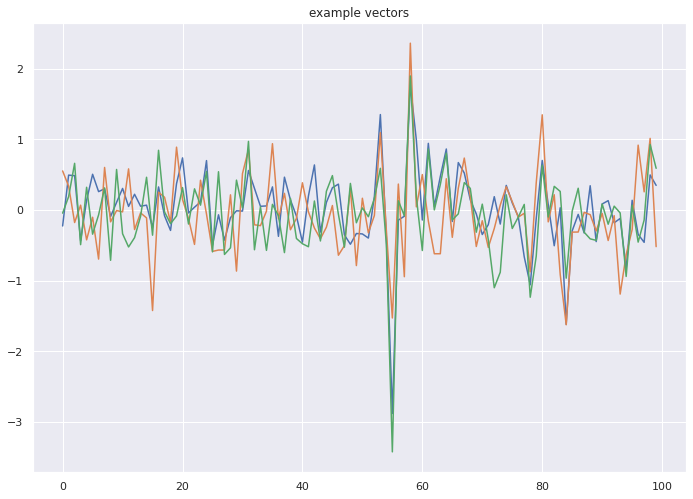

In [26]:
## Peeking at the embedding matrix values
print(embedding_matrix.shape)
plt.plot(embedding_matrix[16])
plt.plot(embedding_matrix[37])
plt.plot(embedding_matrix[18])
plt.title('example vectors')

##Tokenize Text

In [27]:
# Tokenize text

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_news['text'])
#tokenizer.fit_on_texts(test_news['text'])
word_index = tokenizer.word_index
vocab_size=len(word_index)
print(vocab_size)

# Padding data

sequences = tokenizer.texts_to_sequences(train_news['text'])
padded = pad_sequences(sequences, maxlen=500, padding='post', truncating='post')

25669


In [28]:
split = 0.2
split_n = int(round(len(padded)*(1-split),0))

train_data = padded[:split_n]
train_labels = train_news['label_cat'].values[:split_n]
test_data = padded[split_n:]
test_labels = train_news['label_cat'].values[split_n:]

##Word Embeddings

Words are converted to a tensor representation

words with the same meaning have similar tensor values and differences

In [29]:
# Import tensor representations for words

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
print(len(coefs))

embeddings_matrix = np.zeros((vocab_size+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-12-17 05:42:20--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.182.128, 74.125.124.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.182.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  42.8MB/s    in 7.4s    

2020-12-17 05:42:27 (44.8 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]

100


##NLP Topic Modeling

In [30]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)

In [31]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [32]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [33]:
stemmer = SnowballStemmer('english')

In [34]:
processed_docs = train_news['text'].map(preprocess)

In [35]:
processed_docs[:20]

0     [premis, fail, anni, list, make, bone, comfort...
1     [surovel, say, declin, coal, start, natur, tak...
2     [obama, say, vote, amend, present, clinton, ag...
3     [releas, point, mikulski, comment, open, door,...
4     [crist, say, econom, turnaround, start, term, ...
5     [specif, word, fire, mean, faculti, dismiss, c...
6     [determin, signific, detect, work, photo, broa...
7     [sponsor, major, leader, harri, reid, introduc...
8     [johnson, correct, factor, play, role, lotteri...
9     [consid, million, figur, cover, year, reason, ...
10    [senat, correct, latino, voter, obama, win, po...
11    [leav, sander, solid, number, clear, right, un...
12                                                   []
13    [doonesburi, garri, trudeau, say, govern, shut...
14    [talk, problem, health, care, easi, forget, co...
15    [sander, say, elect, novemb, percent, american...
16    [firm, object, america, restrict, repres, gros...
17    [debt, result, cut, spend, measur, democra

###Bag of Words

In [36]:
dictionary = gensim.corpora.Dictionary(processed_docs)

In [37]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 abort
1 anni
2 back
3 bone
4 candid
5 comfort
6 fail
7 hous
8 late
9 limit
10 list


Remove the words with not frequent access

In [38]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [39]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

Sample example of Bag of Word count

In [41]:
bow_doc_4310 = bow_corpus[4310]

for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                                     dictionary[bow_doc_4310[i][0]], 
                                                     bow_doc_4310[i][1]))


Word 13 ("vote") appears 4 time.
Word 47 ("amend") appears 1 time.
Word 62 ("allow") appears 2 time.
Word 72 ("free") appears 1 time.
Word 76 ("includ") appears 1 time.
Word 78 ("legisl") appears 1 time.
Word 80 ("medic") appears 3 time.
Word 99 ("didnt") appears 1 time.
Word 104 ("employ") appears 3 time.
Word 118 ("person") appears 1 time.
Word 121 ("state") appears 1 time.
Word 147 ("work") appears 1 time.
Word 164 ("sponsor") appears 1 time.
Word 245 ("damag") appears 1 time.
Word 259 ("put") appears 1 time.
Word 299 ("worker") appears 1 time.
Word 313 ("gross") appears 1 time.
Word 468 ("exist") appears 1 time.
Word 481 ("busi") appears 3 time.
Word 487 ("small") appears 3 time.
Word 507 ("size") appears 1 time.
Word 518 ("case") appears 2 time.
Word 550 ("lawyer") appears 1 time.
Word 569 ("committe") appears 1 time.
Word 811 ("doctor") appears 2 time.
Word 862 ("fee") appears 1 time.
Word 864 ("interest") appears 1 time.
Word 1008 ("floor") appears 1 time.
Word 1017 ("nurs") app

##TF-IDF

In [42]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)

In [43]:
corpus_tfidf = tfidf[bow_corpus]

In [44]:
from pprint import pprint

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.2508695897656701),
 (1, 0.25148942302563004),
 (2, 0.447231710139766),
 (3, 0.39087527324700394),
 (4, 0.23189250593650343),
 (5, 0.18561391734492397),
 (6, 0.29539416178292016),
 (7, 0.22687886157202766),
 (8, 0.23166587749585685),
 (9, 0.18402044116930108),
 (10, 0.2246172146430015),
 (11, 0.28767341427899423),
 (12, 0.19968757604522677),
 (13, 0.15440512384047242),
 (14, 0.09798923270081467)]


In [45]:
print(corpus_tfidf[1])

[(15, 0.24439504213407562), (16, 0.12401104622201878), (17, 0.10445584830654253), (18, 0.10816898388137834), (19, 0.15742109040566235), (20, 0.24875407887192527), (21, 0.06687157716399575), (22, 0.423131181773295), (23, 0.09087626904910595), (24, 0.09469296535612572), (25, 0.11073864767592327), (26, 0.13315807325623336), (27, 0.0898628072946868), (28, 0.21232382505566252), (29, 0.11866093479066973), (30, 0.1208963810636836), (31, 0.11172564639187192), (32, 0.143855128751491), (33, 0.0912235958840157), (34, 0.5001120146723808), (35, 0.07197638902147854), (36, 0.10203220199317616), (37, 0.07652859648494634), (38, 0.06803481497046107), (39, 0.0987339754053579), (40, 0.10748158340923829), (41, 0.1446112796263864), (42, 0.2747277074535513), (43, 0.06322781591481687), (44, 0.14104372725776498), (45, 0.20921228427138314)]


##LDA using Bag of Words

In [46]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [47]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.025*"state" + 0.008*"immigr" + 0.007*"peopl" + 0.007*"health" + 0.007*"feder" + 0.007*"support" + 0.007*"vote" + 0.007*"govern" + 0.006*"year" + 0.006*"trump"
Topic: 1 
Words: 0.036*"obama" + 0.010*"campaign" + 0.009*"presid" + 0.008*"state" + 0.008*"percent" + 0.008*"year" + 0.008*"public" + 0.007*"romney" + 0.007*"increas" + 0.007*"point"
Topic: 2 
Words: 0.021*"clinton" + 0.014*"number" + 0.012*"percent" + 0.010*"statement" + 0.008*"poll" + 0.007*"support" + 0.007*"accur" + 0.006*"peopl" + 0.006*"point" + 0.005*"trump"
Topic: 3 
Words: 0.013*"year" + 0.008*"money" + 0.008*"million" + 0.008*"statement" + 0.007*"chang" + 0.007*"fund" + 0.007*"spend" + 0.007*"state" + 0.006*"case" + 0.005*"fact"
Topic: 4 
Words: 0.016*"vote" + 0.016*"time" + 0.015*"percent" + 0.014*"year" + 0.008*"state" + 0.007*"american" + 0.007*"number" + 0.006*"leav" + 0.006*"figur" + 0.005*"margin"
Topic: 5 
Words: 0.032*"state" + 0.010*"percent" + 0.009*"number" + 0.008*"unit" + 0.008*"nation" 

##LDA using TF-IDF

In [48]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)

In [49]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.006*"vote" + 0.006*"percent" + 0.004*"support" + 0.004*"obama" + 0.004*"democrat" + 0.004*"republican" + 0.004*"state" + 0.004*"number" + 0.003*"year" + 0.003*"statement"
Topic: 1 Word: 0.005*"obama" + 0.005*"vote" + 0.004*"support" + 0.004*"poll" + 0.004*"state" + 0.004*"percent" + 0.003*"year" + 0.003*"right" + 0.003*"trump" + 0.003*"clinton"
Topic: 2 Word: 0.006*"year" + 0.006*"state" + 0.006*"spend" + 0.006*"billion" + 0.005*"percent" + 0.005*"debt" + 0.004*"number" + 0.004*"budget" + 0.004*"million" + 0.004*"cost"
Topic: 3 Word: 0.004*"state" + 0.004*"percent" + 0.004*"number" + 0.004*"peopl" + 0.004*"year" + 0.003*"obama" + 0.003*"clinton" + 0.003*"immigr" + 0.003*"statement" + 0.003*"children"
Topic: 4 Word: 0.004*"state" + 0.004*"percent" + 0.004*"job" + 0.003*"obama" + 0.003*"year" + 0.003*"number" + 0.003*"clinton" + 0.003*"point" + 0.003*"fact" + 0.003*"statement"
Topic: 5 Word: 0.004*"state" + 0.004*"year" + 0.004*"obama" + 0.004*"percent" + 0.003*"money" +

##Topic Modelling Score

In [50]:
def format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=dictionary):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=dictionary)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.9470,"state, year, abort, plan, vote, cost, peopl, s...",abort
1,1,8.0,0.9800,"state, vote, budget, percent, spend, number, y...",back
2,2,2.0,0.3503,"clinton, number, percent, statement, poll, sup...",candid
3,3,0.0,0.8391,"state, immigr, peopl, health, feder, support, ...",comfort
4,4,6.0,0.8614,"year, plan, health, percent, care, increas, bi...",fail
5,5,7.0,0.4919,"percent, state, rate, rat, year, data, incom, ...",hous
6,6,0.0,0.5638,"state, immigr, peopl, health, feder, support, ...",late
7,7,9.0,0.6567,"state, year, abort, plan, vote, cost, peopl, s...",limit
8,8,9.0,0.5688,"state, year, abort, plan, vote, cost, peopl, s...",list
9,9,9.0,0.9640,"state, year, abort, plan, vote, cost, peopl, s...",make


In [51]:
df_dominant_topic.shape

(11507, 5)

##Combine Modeling Score

Here we add the Topic Modeling Score to the oroginal dataset

In [52]:
train_news = train_news.join(df_dominant_topic)

In [53]:
train_news.head()

,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,context,text,label_cat,sentiment_vector,vader_polarity,sentiment_score,length,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...,1,"[0.113, 0.788, 0.099, -0.1531]",0,-0.1531,11,0,9.0,0.9470,"state, year, abort, plan, vote, cost, peopl, s...",abort
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe...",2,"[0.05, 0.742, 0.208, 0.9593]",0,0.9593,24,1,8.0,0.9800,"state, vote, budget, percent, spend, number, y...",back
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...,3,"[0.059, 0.872, 0.068, 0.1779]",0,0.1779,19,2,2.0,0.3503,"clinton, number, percent, statement, poll, sup...",candid
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...,1,"[0.114, 0.804, 0.082, -0.3058]",0,-0.3058,12,3,0.0,0.8391,"state, immigr, peopl, health, feder, support, ...",comfort
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start...",2,"[0.022, 0.901, 0.077, 0.4384]",0,0.4384,10,4,6.0,0.8614,"year, plan, health, percent, care, increas, bi...",fail


#Tensorflow model

In [56]:
# Build the architecture of the model
     
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 100, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

#Model Training

In [57]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

history = model.fit(train_data, train_labels, epochs=100, batch_size=100, validation_data=[test_data, test_labels])

print("Training Complete")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         2567000   
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 20)          6800      
_________________________________________________________________
lstm_3 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)               

##Results

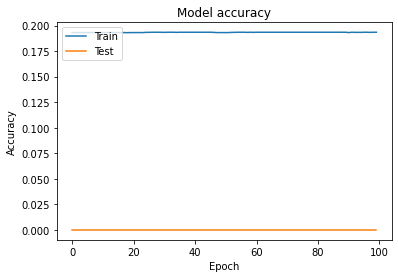

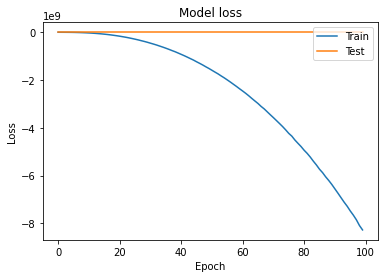

In [ ]:
# Visualize the results:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

#Conclusion

In this program we have used the Liar datset for fake news detection using Neural Network and GRU (Gated Recurrent Network). Since as part of the FEVER paper implementation the authors implemented the GRU method using the Liar liar datset here the Liar dataset is used for implmentation.

From the traning it can be observed that the loss went down after a few initial trainings.

#FEVER Paper Conclusion

From this research the authors have concluded that some of the features explored helped identify dodge statements with an F1 measure as high as 82.57%, however the features were not very effective in identifying false and stretch statements. The truthfulness predictions obtained from training a model on annotations of American politicians’ statements, when used with other features, helped slightly in distinguishing truths from other statements.

#References

https://www.lipad.ca/data/

https://drive.google.com/file/d/1BR5GMRFHdfL7vtQnJI8fN3IWdL4MfpnI/view

https://tspace.library.utoronto.ca/bitstream/1807/101043/4/Naderi_Nona_%20_202006_PhD_thesis.pdf

https://towardsdatascience.com/how-to-build-a-recurrent-neural-network-to-detect-fake-news-35953c19cf0b

https://www.thestar.com/news/canada.html

https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

https://medium.com/analytics-vidhya/keras-embedding-layer-and-programetic-implementation-of-glove-pre-trained-embeddings-step-by-step-7a4b2fa71544

https://pythonmachinelearning.pro/advanced-recurrent-neural-networks/#Gated_Recurrent_Unit_(GRU)

https://github.com/WillKoehrsen/recurrent-neural-networks/blob/master/notebooks/Quick%20Start%20to%20Recurrent%20Neural%20Networks.ipynb

https://towardsdatascience.com/fake-news-classification-with-recurrent-convolutional-neural-networks-4a081ff69f1a

https://www.kaggle.com/stacykurnikova/using-glove-embedding
